In [434]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics

In [435]:
# from google.colab import drive
# drive.mount('/content/drive')

# Lectura de datos

In [436]:
# DIR = "/content/drive/MyDrive/Data Mining Properati/"
#df_train = pd.read_csv(DIR + "properati_entrenamiento.zip", index_col="id")  
#df_test = pd.read_csv(DIR + "properati_a_predecir.zip", index_col="id")  
df_test = pd.read_feather('bases/properati_a_predecir.ftr').set_index('id')
df_train = pd.read_feather('bases/properati_entrenamiento.ftr').set_index('id')

# df_test = pd.read_feather(DIR+'properati_a_predecir.ftr').set_index('id')
# df_train = pd.read_feather(DIR+'properati_entrenamiento.ftr').set_index('id')
# df_test.head()

# Entendimiento (magia parte 1 -- AID)

In [437]:
df_test.head()

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,...,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
id,,,,,,,,,,,,,,,,,,,,,
556713,Propiedad,2019-11-29,9999-12-31,2019-11-29,-58.442399,-34.573623,Argentina,Capital Federal,Colegiales,None,...,2.0,NaN,NaN,NaN,USD,None,"Departamento en Venta en Belgrano, Capital fed...","Sup total por escritura: 96,47 m2 (cubiertos: ...",Departamento,Venta
192912,Propiedad,2020-06-05,2020-06-08,2020-06-05,-58.430493,-34.606620,Argentina,Capital Federal,Almagro,None,...,2.0,77.0,67.0,NaN,USD,None,Departamento de 3 ambientes en Venta en Almagro,Excelente departamento de tres ambientes ampli...,Departamento,Venta
238224,Propiedad,2020-07-01,9999-12-31,2020-07-01,-58.491760,-34.574123,Argentina,Capital Federal,Villa Urquiza,None,...,1.0,60.0,55.0,NaN,USD,None,Andonaegui 2600 4° - - Departamento en Venta,Excelente 3 ambientes al frente con balcón. Vi...,Departamento,Venta
257134,Propiedad,2019-08-17,9999-12-31,2019-08-17,-58.420737,-34.631770,Argentina,Capital Federal,Boedo,None,...,1.0,74.0,47.0,NaN,USD,None,PH Venta Boedo 2 amb Patio,Corredor Responsable: MARCELO TRUJILLO - CPI ...,PH,Venta
521738,Propiedad,2019-08-05,2019-08-31,2019-08-05,-58.429983,-34.607225,Argentina,Capital Federal,Almagro,None,...,1.0,66.0,64.0,NaN,USD,None,Venta 3 Ambientes - Almagro - Balcón - Ameniti...,Corredor Responsable: Marcelo Trujillo - CUCIC...,Departamento,Venta


In [438]:
prueba = df_test.copy()

prueba.start_date = pd.to_datetime(prueba.start_date)

prueba.loc[prueba.end_date=='9999-12-31','end_date'] = np.nan

prueba.end_date = pd.to_datetime(prueba.end_date)
prueba.created_on = pd.to_datetime(prueba.created_on)

In [439]:
train = df_train.copy()

train.start_date = pd.to_datetime(train.start_date)

train.loc[train.end_date=='9999-12-31','end_date'] = np.nan

train.end_date = pd.to_datetime(train.end_date)
train.created_on = pd.to_datetime(train.created_on)

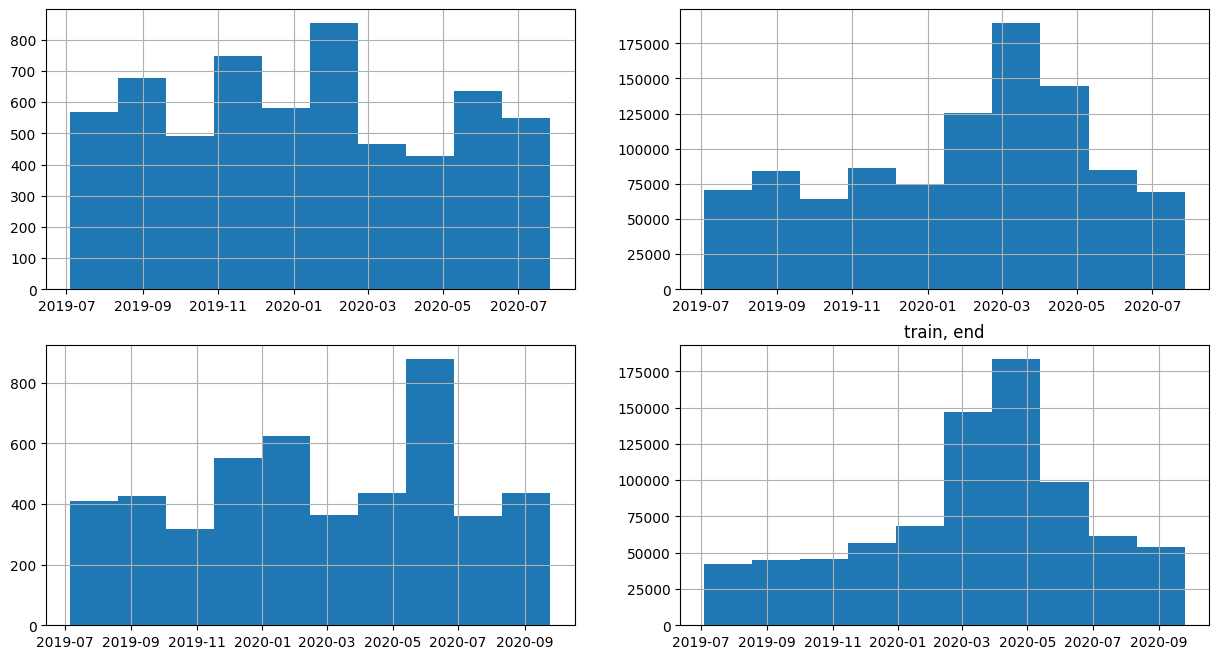

In [440]:
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(15,8))
prueba.start_date.hist(ax=ax[0,0])
ax[0,0] = plt.title('test, start')
prueba.end_date.hist(ax=ax[1,0])
ax[1,0] = plt.title('test, end')
train.start_date.hist(ax=ax[0,1])
ax[0,1] = plt.title('train, start')
train.end_date.hist(ax=ax[1,1])
ax[1,1] = plt.title('train, end')


# Limpieza y transformación de datos (magia parte 2 -- MD)

In [441]:
raro = df_test['surface_total']<df_test['surface_covered']

df_test.loc[raro,'surface_total'], df_test.loc[raro,'surface_covered'] = df_test.loc[raro,'surface_covered'], df_test.loc[raro,'surface_total']

In [442]:
raro = df_train['surface_total']<df_train['surface_covered']

df_train.loc[raro,'surface_total'], df_train.loc[raro,'surface_covered'] = df_train.loc[raro,'surface_covered'], df_train.loc[raro,'surface_total']

In [443]:
en_amba_train = (df_train.lat>-60)&(df_train['lon']>-35.5)&(df_train['lon']<-34)& (df_train.lat<-56.5) & (df_train.l1=='Argentina')
en_amba_test  =  (df_test.lat>-60)&(df_test['lon']>-35.5)&(df_test['lon']<-34)& (df_test.lat<-56.5) & (df_test.l1=='Argentina')

# en_ballester = ((df_train.title.str.upper().str.contains('BALLESTER')) | (df_train.description.str.upper().str.contains('BALLESTER'))&
#                 en_amba_train)
# ballester = df_train[en_ballester]

no_lugares = ['Bs.As. G.B.A. Zona Sur','Bs.As. G.B.A. Zona Norte','Bs.As. G.B.A. Zona Oeste']

#Filtramos los que se encuentran dentro del rango de AMBA y que no son del conurbano
df_train = df_train[en_amba_train & (~df_train.l2.isin(no_lugares))]

#Pulimos la zona circundante a la plata para que coincida con el test
df_train = df_train[(df_train.l2=='Capital Federal')|((df_train.l2=='Buenos Aires Interior')&(df_train.lat>-58.15)&(df_train.lon<-34.7)&(df_train.lon>-35.1))]

# df_train = pd.concat((df_train,ballester),axis=0)

df_train = df_train[(df_train.price_period=='Mensual')|(df_train.price_period.isnull())] #TODO ver si sacarlo 

df_train.loc[df_train.l2=='Buenos Aires Interior','l2'] = 'Bs.As. G.B.A. Zona Sur'

df_train = df_train[df_train.operation_type=='Venta']

df_test.loc[df_test.title.str.contains('en Las Cañitas'),'l3'] = "Las Cañitas"
df_test.loc[((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas')) & (df_test.lat<-58.4),'lat'] = np.nan

df_train.loc[((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas')) & (df_train.lat<-58.47),'l3'] = 'Villa Urquiza'
df_train.loc[((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas')) & (df_train.lat<-58.44),['lat','lon']] = np.nan

df_train.shape

(152720, 24)

In [444]:
df_test.loc[~en_amba_test,['lat','lon']] = np.nan

In [445]:
cols_a_imputar = ['rooms','bedrooms','bathrooms','surface_total','surface_covered','lat','lon']
# crear nuevas columnas para indicar los valores imputados
for column in cols_a_imputar:
    is_imputed_train = np.where(df_train[column].isnull(), True, False)
    is_imputed_test = np.where(df_test[column].isnull(), True, False)
    df_train[column + '_imputed'] = is_imputed_train
    df_test[column + '_imputed'] = is_imputed_test

In [446]:
#df_train['train_test'] = 'train'
#df_test['train_test'] = 'test'

#df = pd.concat((df_train,df_test),axis=0)

#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(dos|2) baños'))   ,'bathrooms'] = 2
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(tres|3) baños'))  ,'bathrooms'] = 3
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(cuatro|4) baños')),'bathrooms'] = 4
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(cinco|5) baños')) ,'bathrooms'] = 5
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(seis|6) baños'))  ,'bathrooms'] = 6
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('baño(\ |\.|\,)'))  ,'bathrooms'] = 1

#df_train = df[df.train_test=='train']
#df_test = df[df.train_test=='test']

#df_train.drop(columns='train_test',inplace=True)
#df_test.drop(columns='train_test',inplace=True)

In [447]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [448]:
imp = IterativeImputer(max_iter=10, random_state=42)  # tiene add_indicator

cols_a_imputar = ['rooms','bedrooms','bathrooms', 'surface_total','surface_covered']
df_test[cols_a_imputar] = imp.fit_transform(df_test[cols_a_imputar])
df_train[cols_a_imputar] = imp.fit_transform(df_train[cols_a_imputar])

cols_a_imputar = ['lat','lon']
df_test[cols_a_imputar] = imp.fit_transform(df_test[cols_a_imputar])
df_train[cols_a_imputar] = imp.fit_transform(df_train[cols_a_imputar])

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [449]:

df_test.rooms      = df_test.rooms.astype('int')
df_train.rooms     = df_train.rooms.astype('int')
df_test.bedrooms   = df_test.bedrooms.astype('int')
df_train.bedrooms  = df_train.bedrooms.astype('int')
df_test.bathrooms  = df_test.bathrooms.astype('int')
df_train.bathrooms = df_train.bathrooms.astype('int')

## Filtrado

In [450]:
pd.concat((df_train.property_type.value_counts(dropna=False),
           df_test.property_type.value_counts(dropna=False)),axis=1).sort_index()

,property_type,property_type
Casa,6878,NaN
Casa de campo,7,NaN
Cochera,2894,NaN
Departamento,97209,5426.0
Depósito,917,NaN
Local comercial,5940,NaN
Lote,8230,NaN
Oficina,4983,NaN
Otro,15649,NaN
PH,10013,574.0


In [451]:
df_train = df_train[df_train.property_type.isin(['PH','Departamento'])]

In [452]:
pd.concat((df_train.bathrooms.value_counts(dropna=False),
           df_test.bathrooms.value_counts(dropna=False)),axis=1)

,bathrooms,bathrooms
1,72464,4605.0
2,23804,1227.0
3,6969,144.0
4,2254,20.0
0,915,NaN
5,633,1.0
6,113,3.0
7,28,NaN
8,12,NaN
11,4,NaN


In [453]:
df_train = df_train[(df_train['bathrooms']<=6) | (df_train['bathrooms'].isnull())]
df_train.shape

(107152, 31)

In [454]:
pd.concat((df_train.currency.value_counts(dropna=False),
           df_test.currency.value_counts(dropna=False)),axis=1)

,currency,currency
USD,102422,6000.0
None,3910,NaN
ARS,820,NaN


In [455]:
df_train = df_train[df_train.currency=='USD'] #saco tambien los nulos porque no tienen precio
df_train.shape

(102422, 31)

In [456]:
pd.concat((df_train.rooms.value_counts(dropna=False),
           df_test.rooms.value_counts(dropna=False)),axis=1).sort_index()

,rooms,rooms
1,20682,NaN
2,30582,2984.0
3,26593,3016.0
4,17756,NaN
5,4668,NaN
6,1264,NaN
7,481,NaN
8,258,NaN
9,46,NaN
10,45,NaN


In [457]:
# df_train = df_train[(df_train.rooms<7) |(df_train.rooms.isnull())]
df_train.shape

(102422, 31)

In [458]:
pd.concat((df_train.bedrooms.value_counts(dropna=False),
           df_test.bedrooms.value_counts(dropna=False)),axis=1).sort_index()

,bedrooms,bedrooms
-1,2,NaN
0,15245,3.0
1,38133,3312.0
2,27821,2660.0
3,16558,23.0
4,3729,1.0
5,507,1.0
6,227,NaN
7,144,NaN
8,22,NaN


In [459]:
# df_train = df_train[(df_train.bedrooms<6) |(df_train.bedrooms.isnull())]
df_train.shape

(102422, 31)

<AxesSubplot: xlabel='surface_covered'>

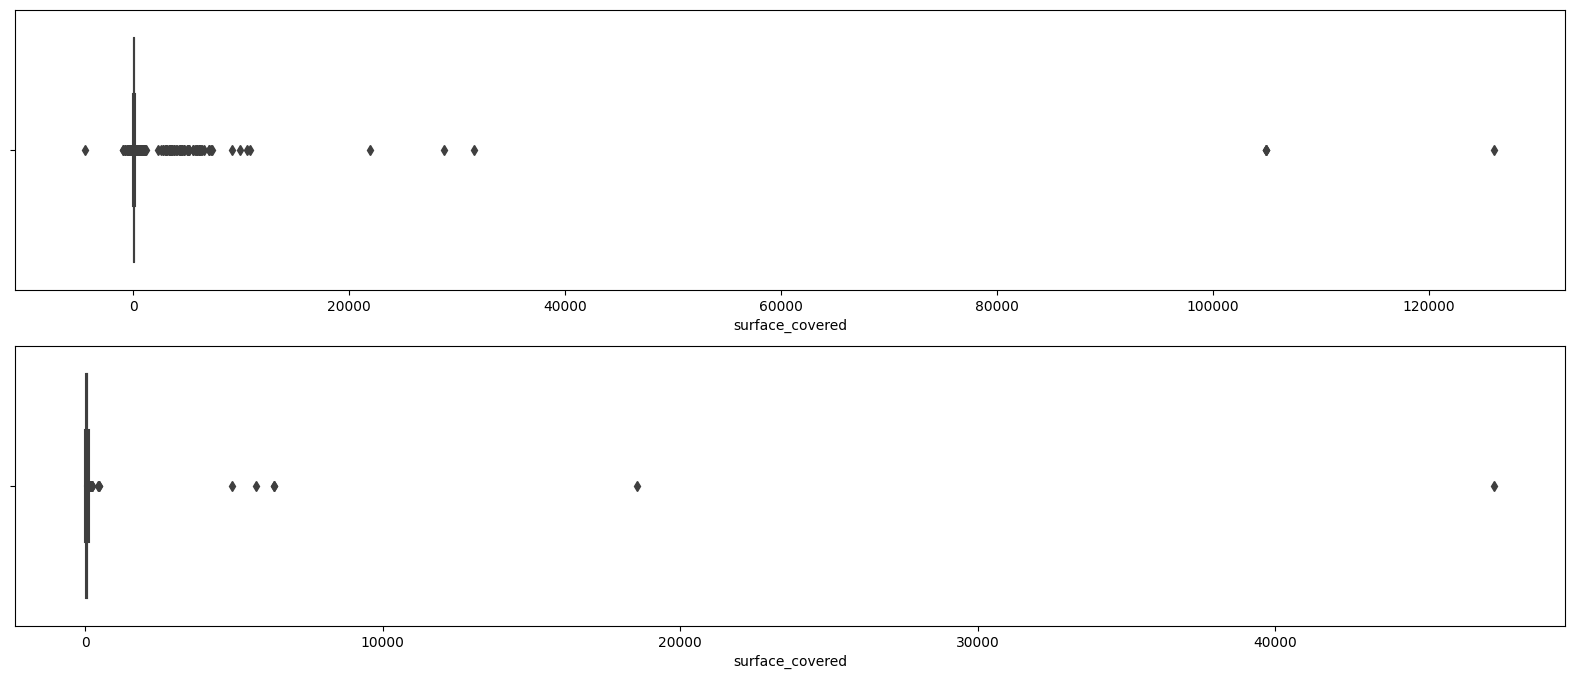

In [460]:
fig, ax = plt.subplots(nrows=2,figsize=(20,8))
sns.boxplot(data=df_train,x='surface_covered',ax=ax[0])
sns.boxplot(data=df_test,x='surface_covered',ax=ax[1])

In [461]:
df_train[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,102422.0,87.192914,720.887917,-4432.263411,41.0,61.0,98.0,126062.0
surface_total,102422.0,138.086412,1024.722444,-149575.086421,43.0,69.0,130.0,126062.0


In [462]:
df_test[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,6000.0,76.894979,672.776879,10.0,45.0,59.000000,76.738295,47360.0
surface_total,6000.0,91.262284,751.427838,21.0,51.0,67.796492,91.032708,47360.0


In [463]:
df_train = df_train[((df_train['surface_covered']>=20)&(df_train['surface_covered']<50000))|(df_train['surface_covered'].isnull())]
df_train.shape

(100591, 31)

<AxesSubplot: xlabel='surface_total'>

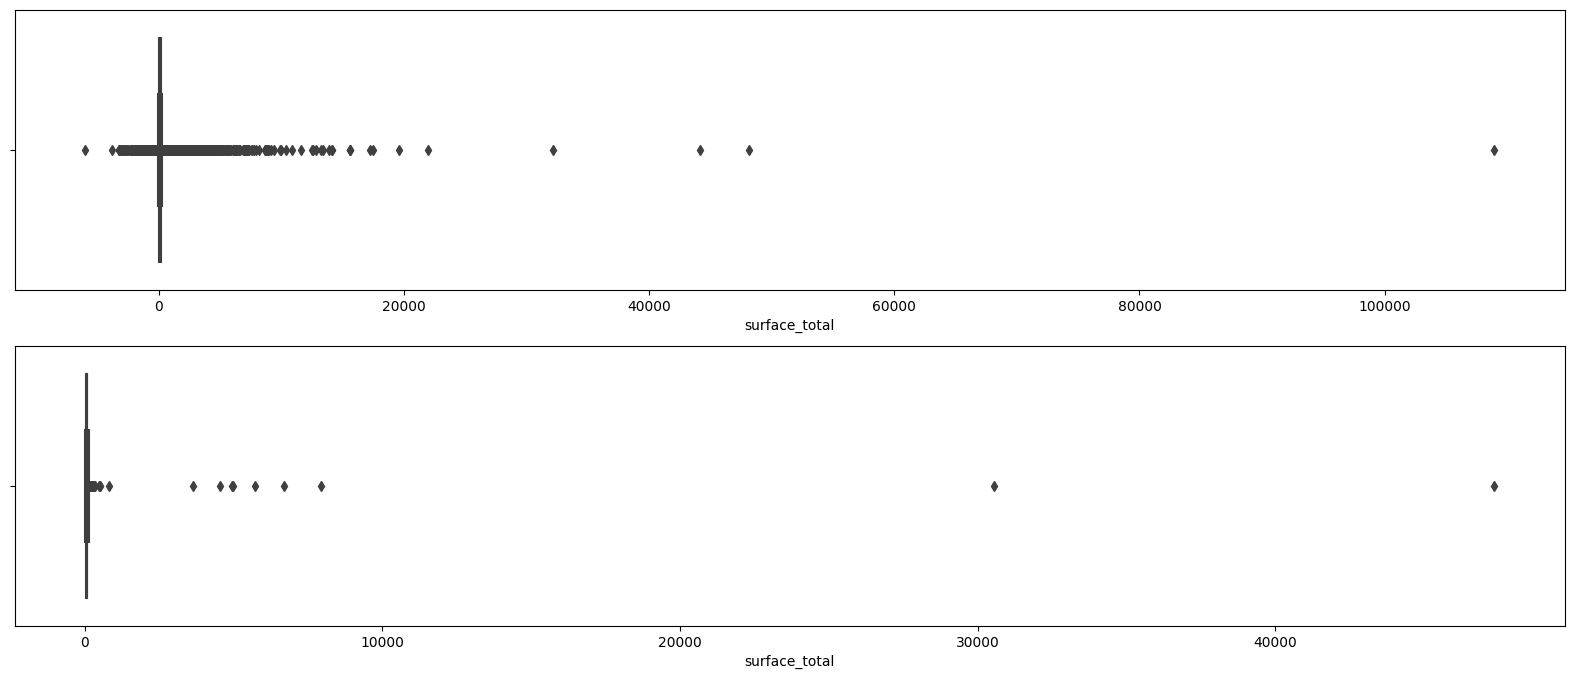

In [464]:
fig, ax = plt.subplots(nrows=2,figsize=(20,8))
sns.boxplot(data=df_train,x='surface_total',ax=ax[0])
sns.boxplot(data=df_test,x='surface_total',ax=ax[1])

In [465]:
df_train[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,100591.0,85.257393,207.768667,20.000000,41.044627,62.0,100.0,31550.0
surface_total,100591.0,146.328567,580.711035,-6008.880032,43.000000,70.0,130.0,108960.0


In [466]:
df_test[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,6000.0,76.894979,672.776879,10.0,45.0,59.000000,76.738295,47360.0
surface_total,6000.0,91.262284,751.427838,21.0,51.0,67.796492,91.032708,47360.0


In [467]:
df_train = df_train[((df_train['surface_total']>=10)&(df_train['surface_total']<50000))|(df_train['surface_total'].isnull())]
df_train.shape

(95914, 31)

In [468]:
df_train[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,95914.0,82.577618,212.001841,20.0,41.0,60.0,91.0,31550.0
surface_total,95914.0,169.079044,457.650534,12.0,46.0,73.0,138.0,48170.0


In [469]:
df_test[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,6000.0,76.894979,672.776879,10.0,45.0,59.000000,76.738295,47360.0
surface_total,6000.0,91.262284,751.427838,21.0,51.0,67.796492,91.032708,47360.0


In [470]:
df_train.price.value_counts().sort_index()

5000.0        1
9500.0        1
10000.0       5
10500.0       2
11111.0       1
             ..
9477000.0     3
11111111.0    1
12345678.0    1
15011160.0    1
32434232.0    1
Name: price, Length: 6371, dtype: int64

## Imputación de nulos

## Armado de variables

In [471]:
df = pd.concat((df_train,df_test),axis=0)

df['bathrooms_rooms'] = df['bathrooms']/df['rooms']
df['bedrooms_rooms'] = df['bedrooms']/df['rooms']
df['covered'] = df['surface_covered']/df['surface_total']

df['start_year']  = pd.to_datetime(df['start_date']).dt.year
df['start_month'] = pd.to_datetime(df['start_date']).dt.month
df['start_day'] = pd.to_datetime(df['start_date']).dt.month

df['tiene_esp_abierto'] = 0
df.loc[(df['surface_total']-df['surface_covered'])!=0,'tiene_esp_abierto'] = 1

df['description'] = df["description"].str.lower().str.replace('á','a').str.replace('é','e').str.replace('í','i').str.replace('ó','o').str.replace('ú','u')
#df['title'] = df["title"].str.lower().str.replace('á','a').str.replace('é','e').str.replace('í','i').str.replace('ó','o').str.replace('ú','u')

for c in ["barrio privado", "corredor",'suite','monoambiente','amueblado',
          'ascensor','parrilla','patio','balcon','jardin','linea (a|b|b|c|d|e|h)',
          'obelisco','catedral','metrobus','barrancas','barrio chino','river',
          'universidad','facultad','subte','tren','estacion','museo','parque','jacuzzi',
          '(j|y)acu(z|zz)i','sho(pp|p)ing','country','terminal','avenida','av.','av',
          'expensa','expensas','a(mm|m)enities','inmobiliaria','dueñ(o|a) direct(o|a)',
          'balcon','pileta|piscina','escuela|colegio','centro','microcentro','lago']:
    df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
    #df[f"title_{c}"] = df["title"].str.contains(c,regex=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_32392\2937259013.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_32392\2937259013.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_32392\2937259013.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_32392\2937259013.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.ex

In [472]:
df.covered.value_counts(dropna=False).sort_index()

0.000851     1
0.004233     1
0.004679     1
0.005105     1
0.007350     1
            ..
19.352209    2
20.143609    1
21.003826    2
24.100608    1
26.738608    1
Name: covered, Length: 5677, dtype: int64

In [473]:
# from sklearn.preprocessing import LabelEncoder

# labelencoder = LabelEncoder()

# df['l3'] = labelencoder.fit_transform(df['l3'])

In [474]:
df_train = df[~df.price.isnull()]
df_test = df[df.price.isnull()]

## Selección de atributos

In [475]:
cols = ['l1','l5','l6','ad_type','currency','operation_type']
df_train.drop(cols,inplace=True,axis=1)
df_test.drop(cols,inplace=True,axis=1)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_32392\2438721469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(cols,inplace=True,axis=1)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_32392\2438721469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(cols,inplace=True,axis=1)


## Dummies

In [476]:
cols_dummies = ['l2','l3','l4','property_type']
train_dummies = pd.get_dummies(df_train[cols_dummies],dummy_na=True)
df_train = pd.concat((df_train,train_dummies),axis=1)

test_dummies = pd.get_dummies(df_test[cols_dummies],dummy_na=True)
df_test = pd.concat((df_test,test_dummies),axis=1)

In [477]:
cols = pd.concat((df_train,df_test),axis=0,join='inner').columns

df_train = df_train[cols]
df_test = df_test[cols]

## Borrado por varianza

In [478]:
from sklearn.feature_selection import VarianceThreshold

In [479]:
# F = df_train[~df_train.price.isnull()]
# X = F[F.select_dtypes(include=['float64' ,'float32','int64', 'int32', 'int16', 'int8', 'bool','uint8']).columns.drop('price')]
# y = F['price']

# print(X.shape)
# fs = VarianceThreshold(threshold=0.005)
# X_new = fs.fit_transform(X) # threshold = limite superior de la varianza
# print(X_new.shape)

# cols = list(X.columns[fs.get_support()])
# cols.append('price')

# df_train = df_train[cols]
# df_test = df_test[cols]

In [480]:
df_train.loc[((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas'))&(df_train.lat<-58.42),'lat'] = -58.361

In [481]:
df_test.loc[((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas'))&(df_test.lat<-58.4),'lat'] = -58.361

<AxesSubplot: xlabel='lat', ylabel='lon'>

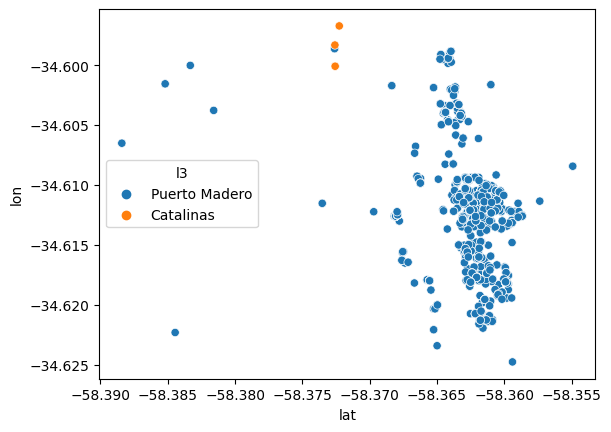

In [482]:
sns.scatterplot(data=df_train[(df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas')],x='lat',y='lon',hue='l3')

In [483]:
df_test_la_plata = df_test[(df_test.lat>-58.2)&(df_test.lon<-34.8)]
df_train_la_plata = df_train[(df_train.lat>-58.2)&(df_train.lon<-34)]

df_test_caba = df_test[(df_test.lat<=-58.2)&(df_test.lon>=-34.8)&~((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas'))]
df_test_madero = df_test[(df_test.lat<=-58.2)&(df_test.lon>=-34.8)&((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas'))]

df_train_caba = df_train[~((df_train.lat>-58.2)&(df_train.lon<-34))&~((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas'))]
df_train_madero = df_train[~((df_train.lat>-58.2)&(df_train.lon<-34))&((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas'))]

corredor_norte = ['Retiro','Las Cañitas','Recoleta','Barrio Norte','Nuñez','Distrito Audiovisual','Palermo','Belgrano']

df_train_corredor_norte = df_train_caba[df_train_caba.l3.isin(corredor_norte)]
df_test_corredor_norte = df_test_caba[df_test_caba.l3.isin(corredor_norte)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(corredor_norte)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(corredor_norte)]

corredor_sur = ['Villa Riachuelo','Villa Lugano','Villa Soldati','Pompeya','Boca','Barracas','Parque Patricios','Constitución']

df_train_corredor_sur = df_train_caba[df_train_caba.l3.isin(corredor_sur)]
df_test_corredor_sur = df_test_caba[df_test_caba.l3.isin(corredor_sur)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(corredor_sur)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(corredor_sur)]

caballito = ['Almagro','Caballito','Parque Centenario','Villa Crespo']

df_train_caballito = df_train_caba[df_train_caba.l3.isin(caballito)]
df_test_caballito= df_test_caba[df_test_caba.l3.isin(caballito)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(caballito)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(caballito)]

# noroeste = ['Saavedra','Villa Ortuzar','Villa Urquiza','Coghlan']

# df_train_noroeste = df_train_caba[df_train_caba.l3.isin(noroeste)]
# df_test_noroeste= df_test_caba[df_test_caba.l3.isin(noroeste)]

# df_train_caba = df_train_caba[~df_train_caba.l3.isin(noroeste)]
# df_test_caba = df_test_caba[~df_test_caba.l3.isin(noroeste)]

# centro = ['San Cristobal','Balvanera','San Nicolás','Monserrat','Congreso','San Telmo','Once','Tribunales','Abasto','Centro / Microcentro']

# df_train_centro = df_train_caba[df_train_caba.l3.isin(centro)]
# df_test_centro= df_test_caba[df_test_caba.l3.isin(centro)]

# df_train_caba = df_train_caba[~df_train_caba.l3.isin(centro)]
# df_test_caba = df_test_caba[~df_test_caba.l3.isin(centro)]

<AxesSubplot: xlabel='price', ylabel='l3'>

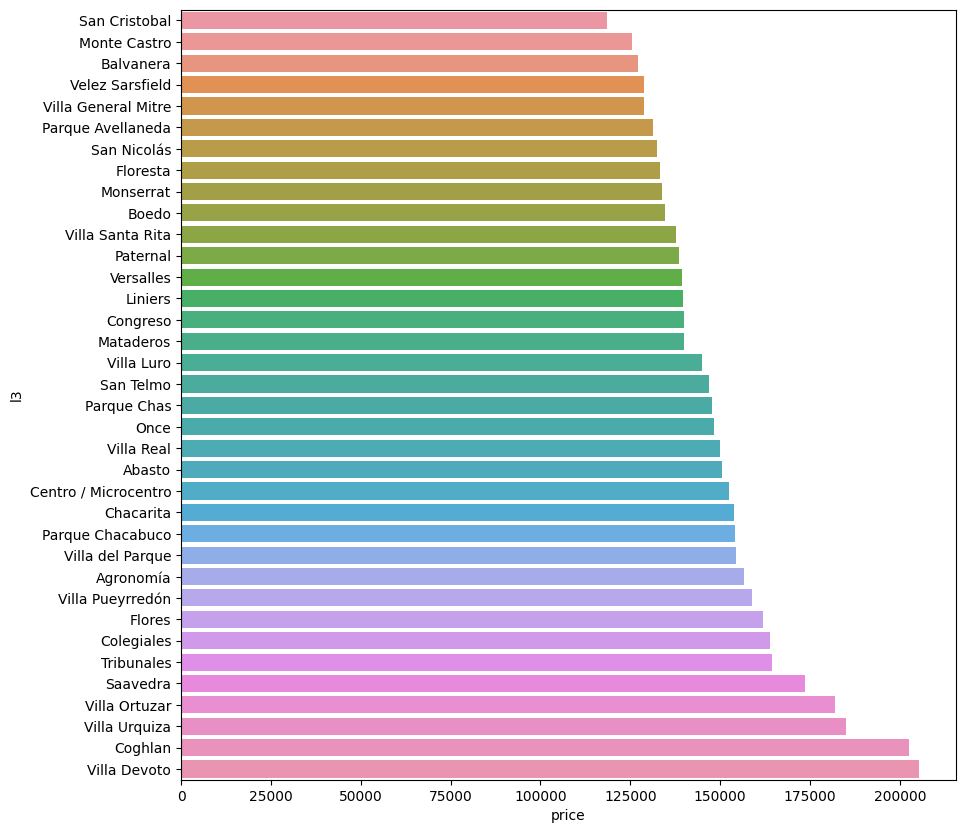

In [484]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=df_train_caba.groupby('l3').agg({'price':'mean'}).reset_index().sort_values('price'),y='l3',x='price')

In [485]:
def filtrado_columnas(df_test,df_train):
    F = df_train[~df_train.price.isnull()]
    X = F[F.select_dtypes(include=['float64' ,'float32','int64', 'int32', 'int16', 'int8', 'bool','uint8']).columns.drop('price')]
    y = F['price']

    clf = sk.ensemble.RandomForestRegressor(n_estimators=50, n_jobs=-1,random_state=42)
    clf.fit(X, y)

    importancias = pd.DataFrame({'atributo': clf.feature_names_in_, 'importancia': clf.feature_importances_})
    cols = list(importancias[importancias['importancia']>0.0001].sort_values('importancia',ascending=False).reset_index(drop=True).atributo)

    cols.append('price')

    display(importancias.sort_values('importancia').tail(10))

    df_train = df_train[cols]
    df_test = df_test[cols]
    return df_test, df_train

In [486]:
# Funcion de limpieza (usada en la siguiente sección) que usa y_train
def limpiar_fold(X_train, y_train, X_test):
    ## TODO: limpiar los datos           
    
    return (X_train, y_train, X_test)

In [487]:
import spacy
import locale
locale.getpreferredencoding = lambda: "UTF-8"
# spacy.cli.download("es_core_news_sm")
from sklearn.feature_extraction.text import CountVectorizer
nlp = spacy.load("es_core_news_sm")
stopwords = nlp.Defaults.stop_words

In [488]:
def tokenizacion(df_test,df_train,columna):
    df = pd.concat((df_test,df_train),axis=0)
    
    df[columna] = df[columna].fillna('NA')

    nlp = spacy.load("es_core_news_sm")
    stopwords = nlp.Defaults.stop_words

    df[columna+'_tok'] = df[columna].apply(lambda texto: [token.text for token in nlp(texto)])
    df[columna+'_tok'] = df[columna+'_tok'].apply(lambda texto: [token for token in texto if token not in stopwords])
    df[columna] = df[columna+'_tok'].str.join(' ')

    vectorizer = CountVectorizer(ngram_range=(1, 3), min_df=0.005, max_df=0.7, strip_accents='ascii', max_features=2000)
    vectorized_data = vectorizer.fit_transform(df[columna])

    count_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

    df = pd.concat((df,count_df),axis=1)

    df_train = df[~df.price.isnull()]
    df_test = df[df.price.isnull()]

    return df_test, df_train

In [489]:
from joblib import Parallel, delayed

def tokenize_text(text):
    nlp = spacy.load("es_core_news_sm")
    stopwords = nlp.Defaults.stop_words
    doc = nlp(text)
    tokens = [token.text for token in doc if token.text not in stopwords]
    return ' '.join(tokens)

def tokenizacion(df_test, df_train, columna):
    df = pd.concat((df_test, df_train), axis=0)

    df[columna] = df[columna].fillna('NA')

    # Tokenización en paralelo
    df[columna + '_tok'] = Parallel(n_jobs=-1)(delayed(tokenize_text)(text) for text in df[columna])

    vectorizer = CountVectorizer(ngram_range=(1, 3), min_df=0.005, max_df=0.7, strip_accents='ascii', max_features=2000)
    vectorized_data = vectorizer.fit_transform(df[columna + '_tok'])

    count_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

    df = pd.concat((df, count_df), axis=1)

    df_train = df[~df.price.isnull()]
    df_test = df[df.price.isnull()]

    return df_test, df_train

In [490]:
print(f"La plata tiene {df_train_la_plata.shape[0]} en train y {df_test_la_plata.shape[0]} en test")
print(f"CABA tiene {df_train_caba.shape[0]} en train y {df_test_caba.shape[0]} en test")
print(f"Pto Madero y Catalinas tiene {df_train_madero.shape[0]} en train y {df_test_madero.shape[0]} en test")
print(f"Corr norte tiene {df_train_corredor_norte.shape[0]} en train y {df_test_corredor_norte.shape[0]} en test")
print(f"Corr sur tiene {df_train_corredor_sur.shape[0]} en train y {df_test_corredor_sur.shape[0]} en test")
print(f"Caballito tiene {df_train_caballito.shape[0]} en train y {df_test_caballito.shape[0]} en test")


La plata tiene 60 en train y 264 en test
CABA tiene 33297 en train y 2231 en test
Pto Madero y Catalinas tiene 1466 en train y 100 en test
Corr norte tiene 33857 en train y 1837 en test
Corr sur tiene 2871 en train y 195 en test
Caballito tiene 24363 en train y 1373 en test


In [491]:
print("La Plata")
df_test_la_plata, df_train_la_plata             = tokenizacion(df_test_la_plata,df_train_la_plata,'description')
# print("Resto de Caba")
# df_test_caba, df_train_caba                     = tokenizacion(df_test_caba,df_train_caba,'title')
print("Madero y Catalinas")
df_test_madero, df_train_madero                 = tokenizacion(df_test_madero,df_train_madero,'description')
# print("Corredor Norte")
# df_test_corredor_norte, df_train_corredor_norte = tokenizacion(df_test_corredor_norte,df_train_corredor_norte,'description')
print("Corredor sur")
df_test_corredor_sur, df_train_corredor_sur     = tokenizacion(df_test_corredor_sur,df_train_corredor_sur,'description')
# print("Caballito")
# df_test_caballito, df_train_caballito           = tokenizacion(df_test_caballito,df_train_caballito,'description')

La Plata
Madero y Catalinas
Corredor sur


In [492]:
print("La Plata")
df_test_la_plata, df_train_la_plata = filtrado_columnas(df_test_la_plata,df_train_la_plata)
print("Resto de Caba")
df_test_caba, df_train_caba = filtrado_columnas(df_test_caba,df_train_caba)
print("Madero y Catalinas")
df_test_madero, df_train_madero = filtrado_columnas(df_test_madero,df_train_madero)
print("Corredor Norte")
df_test_corredor_norte, df_train_corredor_norte = filtrado_columnas(df_test_corredor_norte,df_train_corredor_norte)
print("Corredor sur")
df_test_corredor_sur, df_train_corredor_sur = filtrado_columnas(df_test_corredor_sur,df_train_corredor_sur)
print("Caballito")
df_test_caballito, df_train_caballito = filtrado_columnas(df_test_caballito,df_train_caballito)
# print("Noroeste")
# df_test_noroeste, df_train_noroeste = filtrado_columnas(df_test_noroeste,df_train_noroeste)
# print("Centro")
# df_test_centro, df_train_centro = filtrado_columnas(df_test_centro,df_train_centro)

La Plata


,atributo,importancia
204,25,0.017116
464,autopista,0.017957
1,lon,0.018446
1758,plata bs,0.021757
512,bano dormitorio,0.030265
2,rooms,0.037763
6,surface_total,0.043286
1686,pasillo,0.052474
1059,dormitorio,0.095848
7,surface_covered,0.271790


Resto de Caba


,atributo,importancia
19,start_day,0.013846
11,surface_covered_imputed,0.018351
58,desc_pileta|piscina,0.020228
23,desc_suite,0.020543
16,covered,0.026196
5,surface_total,0.041860
4,bathrooms,0.092865
1,lon,0.131317
0,lat,0.159799
6,surface_covered,0.265466


Madero y Catalinas


,atributo,importancia
11,surface_covered_imputed,0.003338
1860,semi integrada,0.003511
0,lat,0.003638
1,lon,0.003715
995,excelentes,0.004245
294,alvear,0.005329
320,amoblado,0.005556
628,cocheras,0.007394
5,surface_total,0.014468
6,surface_covered,0.815633


Corredor Norte


,atributo,importancia
23,desc_suite,0.011039
16,covered,0.015744
58,desc_pileta|piscina,0.019924
0,lat,0.028122
55,desc_a(mm|m)enities,0.034089
5,surface_total,0.035571
1,lon,0.035976
11,surface_covered_imputed,0.060902
14,bathrooms_rooms,0.181383
6,surface_covered,0.483575


Corredor sur


,atributo,importancia
730,cochera,0.008678
16,covered,0.008753
97,l3_Parque Patricios,0.010365
2080,venta,0.013875
1,lon,0.031976
5,surface_total,0.052116
0,lat,0.056409
70,l3_Barracas,0.082914
6,surface_covered,0.141349
4,bathrooms,0.265903


Caballito


,atributo,importancia
27,desc_parrilla,0.013088
4,bathrooms,0.014365
50,desc_avenida,0.015763
8,bedrooms_imputed,0.016066
40,desc_subte,0.020858
60,desc_centro,0.037474
5,surface_total,0.065352
6,surface_covered,0.151177
1,lon,0.170404
0,lat,0.401193


# Entrenamiento del modelo

## Territorio de Aprendizaje Automático
☢☢☢☢☢☢ Se mira y no se toca ☢☢☢☢☢☢☢

In [493]:
def modelado(df_train,df_test):
    # Datos para probar
    df_train = df_train.select_dtypes(include=['float64', 'int64', 'int32', 'int16', 'int8', 'bool'])

    X = df_train[df_train.columns.drop('price')]
    y = df_train['price']

    # Creamos el modelo
    reg = sk.ensemble.RandomForestRegressor(n_estimators=500, max_depth=5, n_jobs=-1, random_state=42)

    # Partimos en entrenamiento+prueba y validación
    X_train_test, X_val, y_train_test, y_val = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

    scores_train = []
    scores_test = []
    # Validación cruzada, 10 folds, shuffle antes
    kf = sk.model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
    for fold, (train_index, test_index) in enumerate(kf.split(X_train_test, y_train_test)):
        X_train, X_test, y_train, y_test = X_train_test.iloc[train_index], X_train_test.iloc[test_index], y_train_test.iloc[train_index], y_train_test.iloc[test_index]

        X_train, y_train, X_test = limpiar_fold(X_train, y_train, X_test)

        # Entrenamos el modelo
        reg.fit(X_train, y_train)

        # Predecimos en train
        y_pred = reg.predict(X_train)

        # Medimos la performance de la predicción en test
        score_train = sk.metrics.mean_squared_error(y_train, y_pred,squared=False).round()
        scores_train.append(score_train)

        # Predecimos en test
        y_pred = reg.predict(X_test)    

        # Medimos la performance de la predicción en test
        score_test = sk.metrics.mean_squared_error(y_test, y_pred,squared=False).round()
        scores_test.append(score_test)
        
        print(f"{fold=}, {score_train=} {score_test=}")
        

    print(f"Train scores mean={pd.Series(scores_train).mean()}, std={pd.Series(scores_train).std()}")
    print(f"Test scores mean={pd.Series(scores_test).mean()}, std={pd.Series(scores_test).std()}")

    ## Datos a predecir 
    X = df_train[df_train.columns.drop('price')]
    y = df_train['price']
    X_prueba = df_test[df_train.columns.drop('price')] # cuidado:

    # Entrenamos el modelo con todos los datos
    reg.fit(X, y)

    # Predecimos
    df_test['price'] = reg.predict(X_prueba)

    # Grabamos
    # df_test['price'].to_csv('solucion_la_plata.csv', index=True)

    display(pd.DataFrame(zip(df_train.columns.drop('price'), 
                             reg.feature_importances_*100), 
                         columns=["column", "feature_importance"]).sort_values(by="feature_importance", ascending=False).head(10))

    return df_test['price']

In [494]:
print("Resto de CABA")
solucion_caba = modelado(df_train_caba,df_test_caba)
print("La Plata")
solucion_la_plata = modelado(df_train_la_plata,df_test_la_plata)
print("Puerto Madero y Catalinas")
solucion_madero = modelado(df_train_madero,df_test_madero)
print("Corredor Norte")
solucion_corredor_norte = modelado(df_train_corredor_norte,df_test_corredor_norte)
print("Corredor Sur")
solucion_corredor_sur = modelado(df_train_corredor_sur,df_test_corredor_sur)
print("Caballito")
solucion_caballito = modelado(df_train_caballito,df_test_caballito)
# print("Noroeste")
# solucion_noroeste = modelado(df_train_noroeste,df_test_noroeste)
# print("Centro")
# solucion_centro = modelado(df_train_centro,df_test_centro)

Resto de CABA
fold=0, score_train=95479.0 score_test=57108.0
fold=1, score_train=97816.0 score_test=51359.0
fold=2, score_train=95532.0 score_test=78328.0
fold=3, score_train=95595.0 score_test=53826.0
fold=4, score_train=95411.0 score_test=69299.0
fold=5, score_train=93397.0 score_test=85791.0
fold=6, score_train=94491.0 score_test=82364.0
fold=7, score_train=62428.0 score_test=253449.0
fold=8, score_train=95387.0 score_test=62280.0
fold=9, score_train=94378.0 score_test=55461.0
Train scores mean=91991.4, std=10449.609532311615
Test scores mean=84926.5, std=60501.48986457551


,column,feature_importance
0,surface_covered,56.547312
3,bathrooms,15.799908
2,lon,5.312617
6,desc_suite,3.887439
4,surface_total,3.680048
8,surface_covered_imputed,3.377092
7,desc_pileta|piscina,2.607506
1,lat,1.663913
9,start_day,1.090057
42,start_year,0.933592


La Plata
fold=0, score_train=8390.0 score_test=61791.0
fold=1, score_train=9713.0 score_test=19453.0
fold=2, score_train=10993.0 score_test=22136.0
fold=3, score_train=10880.0 score_test=27116.0
fold=4, score_train=10980.0 score_test=13735.0
fold=5, score_train=9934.0 score_test=37256.0
fold=6, score_train=10266.0 score_test=22440.0
fold=7, score_train=10821.0 score_test=7721.0
fold=8, score_train=11185.0 score_test=10119.0
fold=9, score_train=10716.0 score_test=7947.0
Train scores mean=10387.8, std=853.5848327299792
Test scores mean=22971.4, std=16500.339506271444


,column,feature_importance
0,surface_covered,26.121694
2,pasillo,7.461533
5,bano dormitorio,6.313249
1,dormitorio,6.304603
3,surface_total,5.505675
4,rooms,3.189154
7,lon,2.806421
13,bathrooms,2.538298
19,mts,2.049968
18,consta,1.616701


Puerto Madero y Catalinas
fold=0, score_train=178823.0 score_test=220512.0
fold=1, score_train=178174.0 score_test=234149.0
fold=2, score_train=177049.0 score_test=221626.0
fold=3, score_train=180904.0 score_test=183760.0
fold=4, score_train=174806.0 score_test=263824.0
fold=5, score_train=178308.0 score_test=192065.0
fold=6, score_train=173419.0 score_test=378624.0
fold=7, score_train=181327.0 score_test=147473.0
fold=8, score_train=165395.0 score_test=427007.0
fold=9, score_train=173555.0 score_test=328847.0
Train scores mean=176176.0, std=4687.696686243919
Test scores mean=259788.7, std=90374.06529905456


,column,feature_importance
0,surface_covered,86.045254
2,cocheras,0.910046
1,surface_total,0.877145
5,excelentes,0.861889
4,alvear,0.516843
3,amoblado,0.497395
12,real,0.445198
15,diario,0.384339
10,covered,0.315167
8,semi integrada,0.306127


Corredor Norte
fold=0, score_train=175357.0 score_test=637186.0
fold=1, score_train=194285.0 score_test=163432.0
fold=2, score_train=190108.0 score_test=196686.0
fold=3, score_train=194474.0 score_test=242532.0
fold=4, score_train=191592.0 score_test=183442.0
fold=5, score_train=190515.0 score_test=207057.0
fold=6, score_train=193944.0 score_test=173666.0
fold=7, score_train=192647.0 score_test=156287.0
fold=8, score_train=189927.0 score_test=216826.0
fold=9, score_train=194013.0 score_test=200673.0
Train scores mean=190686.2, std=5672.244721252582
Test scores mean=237778.7, std=142683.92062570408


,column,feature_importance
0,surface_covered,60.564338
1,bathrooms_rooms,19.476624
2,surface_covered_imputed,7.859003
5,desc_a(mm|m)enities,4.119902
7,desc_pileta|piscina,2.263380
4,surface_total,1.438625
9,desc_suite,1.157876
3,lon,1.076863
8,covered,0.602573
6,lat,0.518461


Corredor Sur
fold=0, score_train=45367.0 score_test=40927.0
fold=1, score_train=44678.0 score_test=40555.0
fold=2, score_train=45439.0 score_test=37905.0
fold=3, score_train=44994.0 score_test=42182.0
fold=4, score_train=43196.0 score_test=73276.0
fold=5, score_train=46095.0 score_test=46150.0
fold=6, score_train=42520.0 score_test=81551.0
fold=7, score_train=45683.0 score_test=38687.0
fold=8, score_train=45754.0 score_test=40778.0
fold=9, score_train=39631.0 score_test=92820.0
Train scores mean=44335.7, std=2013.3772649732368
Test scores mean=53483.1, std=20699.596284039508


,column,feature_importance
0,bathrooms,36.622131
1,surface_covered,19.303132
2,lat,10.712168
3,surface_total,5.259673
4,lon,2.920194
26,surface_covered_imputed,1.232062
15,baulera,1.054937
8,desc_pileta|piscina,0.895135
88,piscina,0.884762
7,cochera,0.812407


Caballito
fold=0, score_train=129374.0 score_test=126308.0
fold=1, score_train=123943.0 score_test=51563.0
fold=2, score_train=61451.0 score_test=341421.0
fold=3, score_train=124889.0 score_test=88268.0
fold=4, score_train=128144.0 score_test=58139.0
fold=5, score_train=130239.0 score_test=119575.0
fold=6, score_train=126870.0 score_test=71678.0
fold=7, score_train=125533.0 score_test=84358.0
fold=8, score_train=126367.0 score_test=66550.0
fold=9, score_train=125060.0 score_test=44322.0
Train scores mean=120187.0, std=20736.63503185713
Test scores mean=105218.2, std=87298.3204392336


,column,feature_importance
0,lat,37.657968
2,surface_covered,23.701649
4,desc_centro,9.348639
3,surface_total,6.958776
6,bedrooms_imputed,6.058269
7,desc_avenida,3.630356
1,lon,3.063785
5,desc_subte,2.868881
8,bathrooms,2.156723
12,desc_estacion,1.615406


## Entrega final

In [495]:
pd.concat((solucion_caba,solucion_la_plata,
           solucion_madero,
           solucion_corredor_norte,
           solucion_corredor_sur,
           solucion_caballito
        #    solucion_noroeste,solucion_centro
           )).to_csv('solucion.csv', index=True)